# Tests for homogeneous Dirichlet condition at the left boundary

<IPython.core.display.Javascript object>


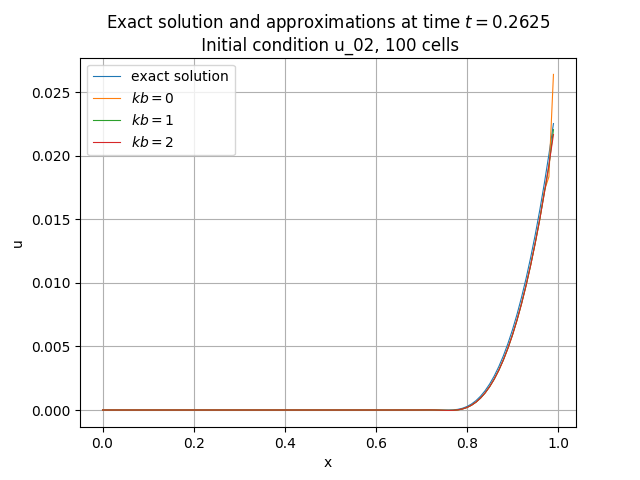

In [1]:
%matplotlib notebook

import numpy as np
import scipy.special as special
import scipy.integrate as integrate
import scipy.misc as misc
import matplotlib.pyplot as plt

a = 1.

# initial conditions

def u_00(x):
    if x-0.5 > 0:
        return((x-0.5)**5)
    else:
        return(0.)

def u_01(x):
    if x-0.5 > 0:
        return((x-0.5)**3)
    else:
        return(0.)
        
def u_02(x):
    if x-0.5 > 0:
        return((x-0.5)**2.6)
    else:
        return(0.)
        
def u_03(x):
    if x-0.5 > 0:
        return((x-0.5)**2.5)
    else:
        return(0.)

def u_04(x):
    return(0.25+0.5*np.sin(np.pi*(x-1)))

def u_05(x):
    if x-0.5 < 0:
        return((-x+0.5)**3)
    else:
        return(0.)
    
# inflow theoretical dirichlet condition

def g1(t):
    return(0.25-0.5*np.sin(np.pi*(1+t)))

def g2(t):
    if t <= 1:
        return(0.25)
    else:
        return(-1)
        
# schemes; mu stands for lambda in cl18

def lw(mu): #lax wendroff, returns a_l coefficients and r,p
    return(([((a**2)*(mu**2)+a*mu)/2,1-(a**2)*(mu**2),((a**2)*(mu**2)-a*mu)/2],1,1,2))

def bw(mu):
    nu = a*mu
    return(([0.5*(nu**2-nu),2*nu-nu**2,1-1.5*nu+0.5*nu**2],2,0,2))

def O3(mu):
    alpha = (1+a*mu)/3
    return(((1-alpha)*np.array([0]+lw(mu)[0])+alpha*np.array(bw(mu)[0]+[0]),2,1,3))

def u_exact(u_0,g):
    def u(t,x):
        if x <= a*t:
            return(g(t-x/a))
        else:
            return(u_0(x-a*t))
    return(u)
        
def cl(u_0,g,t,J,mu,kb,scheme,inflow_treatment): #g(t) is the dirichlet condition at the left boundary

    b, r, p, k = scheme(mu) #b represents coefficients a_l in cl18, numbered in python here, ie from index 0
    dx, N, dt = 1/J, int(np.ceil(t*J/mu)), mu/J
    u = np.zeros(J+r+p) #u numbered in python here, ie from index 0
    
    for j in range(J):
        #u[r+j] = u_0((j+0.5)*dx)
        u[r+j] = (1/dx)*integrate.quad(u_0,j*dx,(j+1)*dx)[0]
        
    for n in range(N): #note l stand for -l in CL18
        if inflow_treatment == 'homogeneous':
            for l in range(r):
                u[r-1-l] = 0
        elif inflow_treatment == 'naive':
            for l in range(r):
                u[r-1-l] = g(n*dt-(l-0.5)*dx/a) #(dx/(a*dt))*g(-(l-0.5)*dx/a)
        elif inflow_treatment == 'ILW':
            for l in range(r): #-l compensates with -a
                u[r-1-l] = sum([((l*dx/a)**m)*misc.derivative(g,n*dt,n = m)/special.factorial(m)
                                for m in range(k)]) # ILW goes up to m=k-1
        elif inflow_treatment == 'RILW': # rectified ILW
            for l in range(r):
                u[r-1-l] = sum([((-dx/a)l**m)*((-l)**(m+1)-(-l-1)**(m+1))*misc.derivative(g,n*dt,n = m)/
                                special.factorial(m+1)
                                for m in range(k)]) # RILW also goes up to m=k-1

        u[r+J:r+J+p] = sum([special.binom(kb,k)*((-1)**(k+1))*u[r+J-k:r+J+p-k] for k in range(1,kb+1)])
        u[r:r+J] = sum([b[r+l]*u[r+l:r+J+l] for l in range(-r,p+1)])
        #here the interior values of u are at step n+1 whereas the extreme values are at step n
        
    return(u[r:r+J])
    
def sol_plot(u_0,g,t,J,mu,scheme,inflow_treatment):
    plt.clf()
    plt.plot(np.arange(0,1,1/J),[u_exact(u_0,g)(t,(j+0.5)/J) for j in range(J)],linewidth = .8, 
             label = 'exact solution')
    #same number of cells for both the exact solution and the approximation
    
    for kb in range(3):
        plt.plot(np.arange(0,1,1/J),cl(u_0,g,t,J,mu,kb,scheme,inflow_treatment),linewidth = .8, 
                 label = '$kb =$'+str(kb))
    
    plt.grid()
    plt.title(f'Exact solution and approximations at time $t = {t}$\n Initial condition {u_0.__name__}, {J} cells')
    plt.xlabel('x')
    plt.ylabel('u')
    plt.legend()
    plt.show()

J = 40

t = 0.2625

sol_plot(u_02,lambda t : 0, t, 100, 0.7, lw, 'homogeneous')

<IPython.core.display.Javascript object>


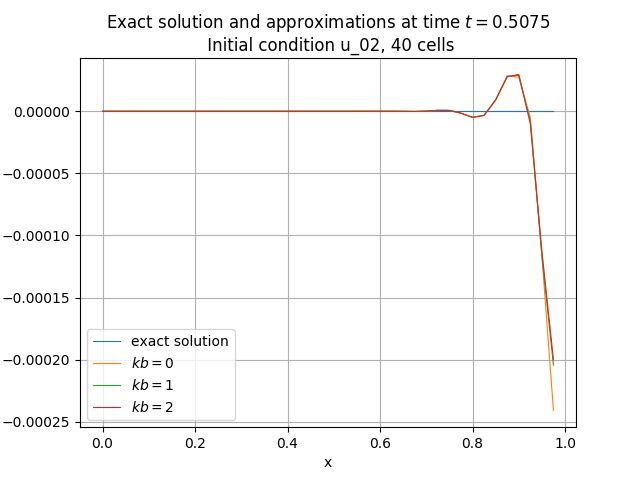

In [2]:
%matplotlib notebook

t = 0.5075

sol_plot(u_02,lambda t : 0, t,J, 0.7, lw, 'homogeneous')

## Error evaluation

Here comes the error evaluation part. Now it works.

<IPython.core.display.Javascript object>


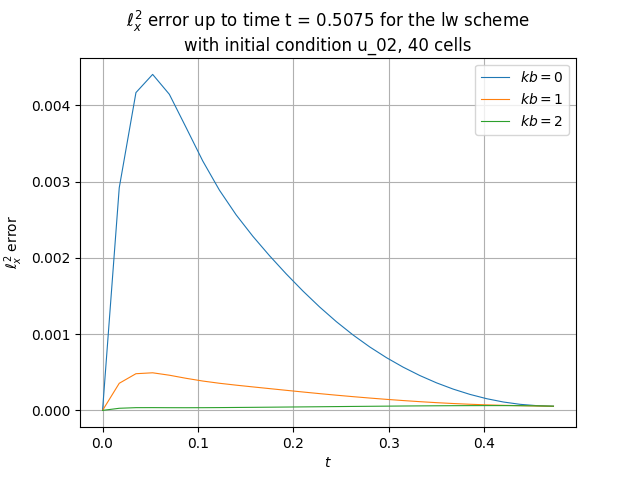

In [3]:
%matplotlib notebook

def error_l2x(u_0,g,t,J,mu,scheme,inflow_treatment): #plot errors at each time up to time t
    b, r, p, k = scheme(mu) #b represents coefficients a_l in cl18, numbered in python here, ie from index 0
    dx, N, dt = 1/J, int(t*J/mu), mu/J
    plt.clf()
    for kb in range(3):
        error = []
        for n in range(N):
            u = np.array([u_exact(u_0,g)(n*dt,(j+0.5)*dx) for j in range(J)])
            error.append(np.sqrt(dx)*np.linalg.norm(cl(u_0,g,n*dt,J,mu,kb,scheme,inflow_treatment)-u))
            #error.append(np.linalg.norm(cl(u_0,f,n*dt,J,mu,kb,scheme)-u_exact, ord = np.inf))
        plt.plot(np.arange(0,t-dt,dt),error,linewidth = .8, label = '$kb =$'+str(kb))
    plt.title(f'$\ell^2_x$ error up to time t = {t} for the {scheme.__name__} scheme\n'+
              f'with initial condition {u_0.__name__}, {J} cells')
    plt.grid()
    plt.xlabel('$t$')
    plt.ylabel('$\ell^2_x$ error')
    plt.legend()
    plt.show()
    
error_l2x(u_02,lambda t : 0,t,40,0.7,lw, 'homogeneous')

Next I plot the $\ell^{\infty}_t \ell^{2}_x$ and then $\ell^{\infty}_t \ell^{\infty}_x$ error in log-log scale. We should get a straight line which slope is the opposite of the order of convergence.
That's ok, at least at the beginning. I think the problem for $\Delta_x$ small is that the error is too small for my computer, so it gets unaccurate. I shall test it on a more accurate computer.

In [4]:
%matplotlib notebook

def error_linftyt_l2x(u_0,g,t,mu,kb,scheme,inflow_treatment):
    b, r, p, k = scheme(mu)
    error = []
    for J in [10*(2**i) for i in range(7)]:
        dx, N, dt = 1/J, int(t*J/mu), mu/J
        error_Jcells = [] #error for a given number of cells, J, at each time
        for n in range(N):
            u = np.array([u_exact(u_0,g)(n*dt,(j+0.5)*dx) for j in range(J)])
            error_Jcells.append(np.sqrt(dx)*np.linalg.norm(cl(u_0,g,n*dt,J,mu,kb,scheme,
                                                              inflow_treatment)-u)) #computes again and again at ndt : bad?
        error.append(max(error_Jcells))
    plt.clf()
    plt.plot([i*np.log10(2) for i in range(7)],np.log10(error),marker = '+',linewidth=.8,label = '$kb =$'+str(kb))
    plt.title('$\log$ of $\ell^{\infty}_t \ell^2_x$ error \n'
              +f'for the {scheme.__name__} scheme with initial condition {u_0.__name__}')
    plt.xlabel('$-\log(\Delta_x)+$constant')
    plt.ylabel('$\log$ of $\ell^{\infty}_t \ell^{\infty}_x$ error')
    plt.grid()
    plt.legend()
    plt.show()
    return(error)
    
def error_linftyt_linftyx(u_0,g,t,mu,kb,scheme,inflow_treatment):
    b, r, p, k = scheme(mu)
    error = []
    for J in [10*(2**i) for i in range(7)]:
        dx, N, dt = 1/J, int(t*J/mu), mu/J
        error_Jcells = [] #error for a given number of cells, J, at each time
        for n in range(N):
            u = np.array([u_exact(u_0,g)(n*dt,(j+0.5)*dx) for j in range(J)])
            error_Jcells.append(np.linalg.norm(cl(u_0,g,n*dt,J,mu,kb,scheme,inflow_treatment)-u, 
                                               ord = np.inf)) #computes again and again at ndt : bad?
        error.append(max(error_Jcells))
    plt.clf()
    plt.plot([i*np.log10(2) for i in range(7)],np.log10(error),marker = '+',linewidth=.8,label = '$kb =$'+str(kb))
    plt.title('$\log$ of $\ell^{\infty}_t \ell^{\infty}_x$ error \n'
              +f'for the {scheme.__name__} scheme with initial condition {u_0.__name__}')
    plt.xlabel('$-\log(\Delta_x)+$constant')
    plt.ylabel('$\log$ of $\ell^{\infty}_t \ell^{\infty}_x$ error')
    plt.grid()
    plt.legend()
    plt.show()
    return(error)

#error_linftyt_l2x(u_01,lambda t : 0,t,0.7,2,lw, 'homogeneous')

<IPython.core.display.Javascript object>


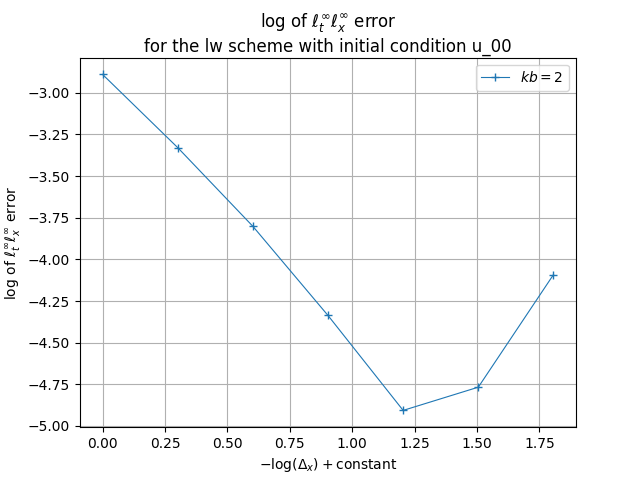

[0.0012888581999999944,
 0.0004686276000000038,
 0.00015793624013671348,
 4.6047839657583495e-05,
 1.2398293886092815e-05,
 1.7090212058124086e-05,
 8.093579313791198e-05]

In [11]:
%matplotlib notebook

error_linftyt_linftyx(u_01,lambda t : 0,t,0.7,2,lw, 'homogeneous')

In the end, we get order $\sim 1.83$ v. order $\sim 1.9$ for CL18.

## Other schemes (Beam-warming, O3)

### Beam-warming

<IPython.core.display.Javascript object>


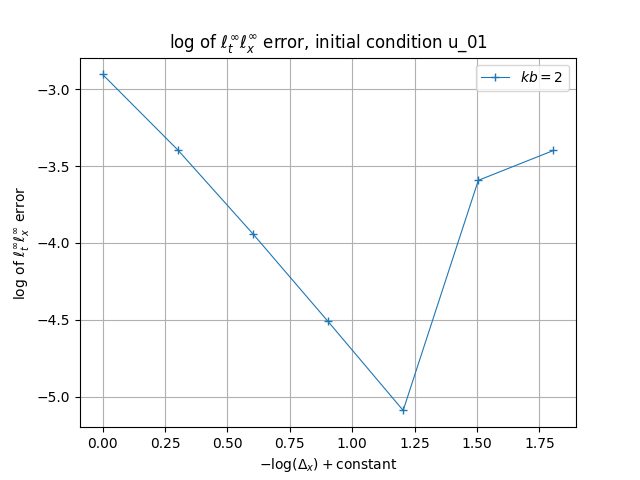

[0.001245862050666408,
 0.0004029994470501377,
 0.00011476145667885864,
 3.092622231409401e-05,
 8.164526665547892e-06,
 0.0002552366027833248,
 0.0003991225929256756]

In [16]:
%matplotlib notebook

#error_linftyt_l2x(u_01,lambda t : 0,t,0.7,2,bw, 'homogeneous')

error_linftyt_linftyx(u_01,lambda t : 0,t,0.7,2,bw, 'homogeneous')

The order seems to be maintained around 1.83

### O3 scheme

<IPython.core.display.Javascript object>


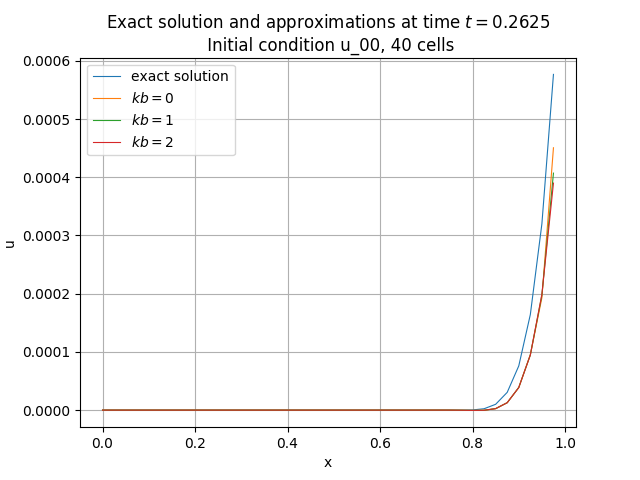

In [24]:
%matplotlib notebook

sol_plot(u_00,lambda t : 0, t,J, 0.7, O3, 'homogeneous')

<IPython.core.display.Javascript object>


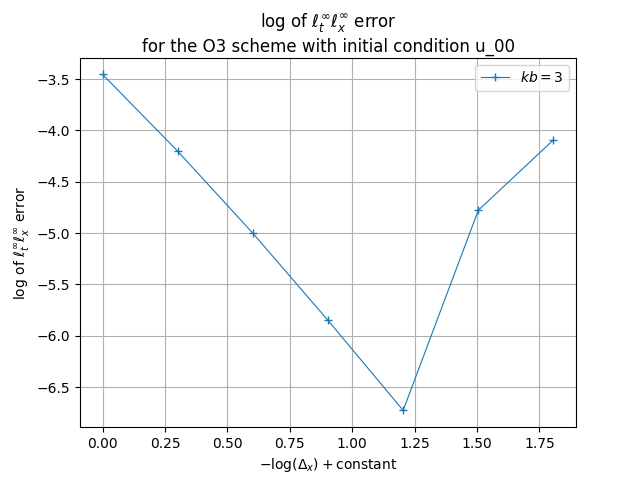

[0.00035173319999999564,
 6.281900625000267e-05,
 9.98534157714212e-06,
 1.4152725150949619e-06,
 1.878484437688177e-07,
 1.6697276010603837e-05,
 8.097144319960028e-05]

In [9]:
%matplotlib notebook

#error_linftyt_l2x(u_00,lambda t : 0,t,0.7,3,O3, 'homogeneous')

error_linftyt_linftyx(u_00,lambda t : 0,t,0.7,3,O3, 'homogeneous')

The order seems to be $\sim 2.8$.

# Tests for non-homogeneous Dirichlet condition at the left boundary

## Naive numerical boundary condition

### Short time solution plots

<IPython.core.display.Javascript object>


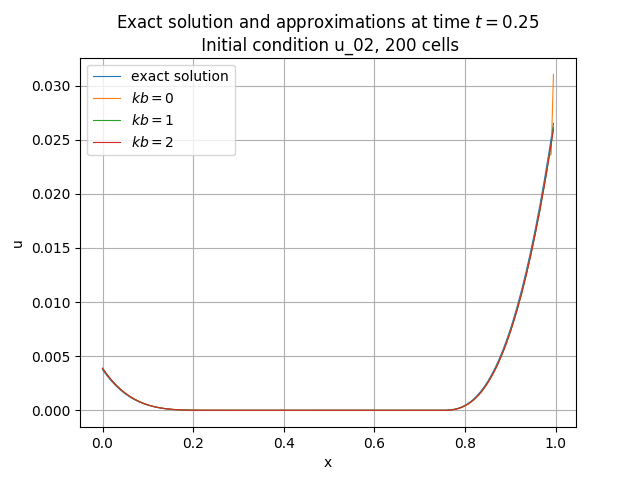

In [49]:
%matplotlib notebook

t=0.25

sol_plot(u_02,lambda t : t**4, t,200, 0.7, lw, 'naive')

<IPython.core.display.Javascript object>


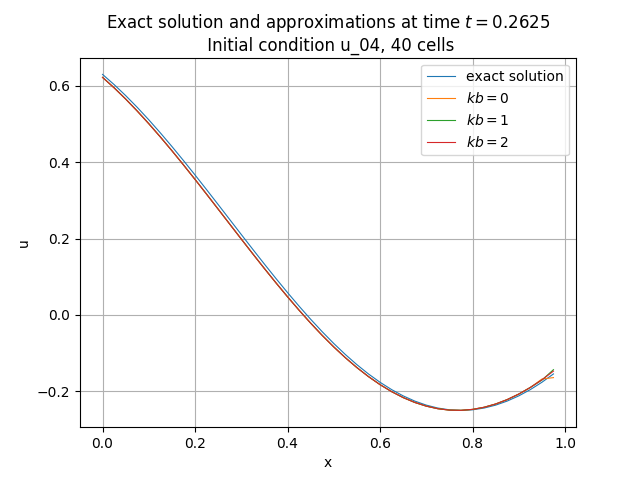

In [134]:
%matplotlib notebook

sol_plot(u_04,g1, t, 40, 0.7, lw, 'naive')

<IPython.core.display.Javascript object>


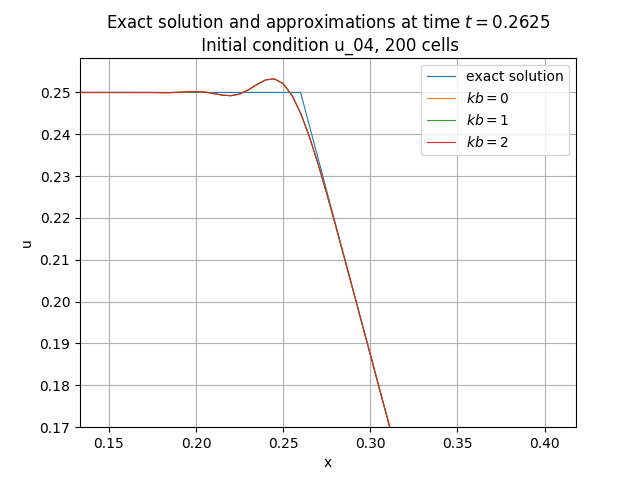

In [141]:
%matplotlib notebook

sol_plot(u_04,g2, t, 200, 0.7, lw, 'naive')

### Long time solution plots

<IPython.core.display.Javascript object>


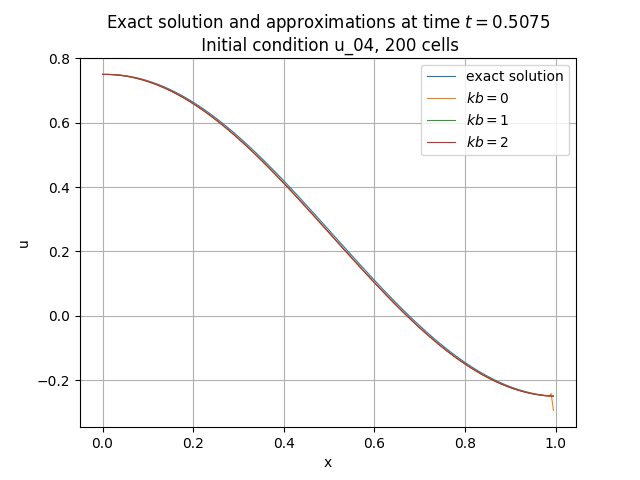

In [136]:
%matplotlib notebook

t = 0.5075

sol_plot(u_04,g1, t, 200, 0.7, lw, 'naive')

### Error plots

<IPython.core.display.Javascript object>


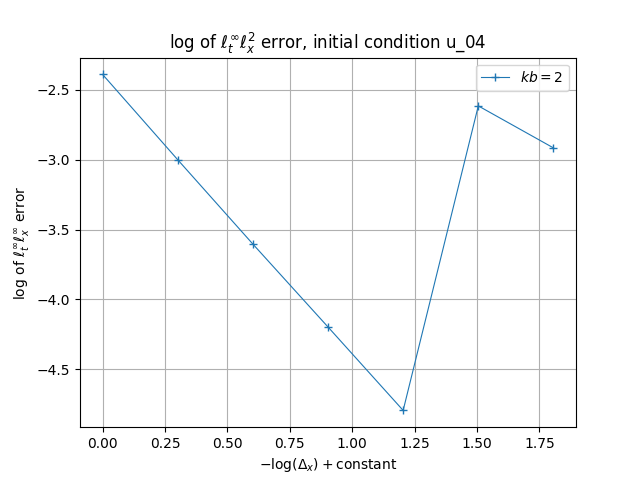

[0.004080512858436137,
 0.000999694635970885,
 0.0002488977698801112,
 6.341431147189214e-05,
 1.6025739465124685e-05,
 0.0024274602208205717,
 0.0012145515218374586]

In [137]:
%matplotlib notebook

#error_linftyt_l2x(u_04,g1,t,0.7,2,lw, 'naive')

error_linftyt_linftyx(u_04,g1,t,0.7,2,lw, 'naive')

For $r = 1$ (Lax-Wendroff here), the naive method still seems to guarantee a order a bit less than 2.

<IPython.core.display.Javascript object>


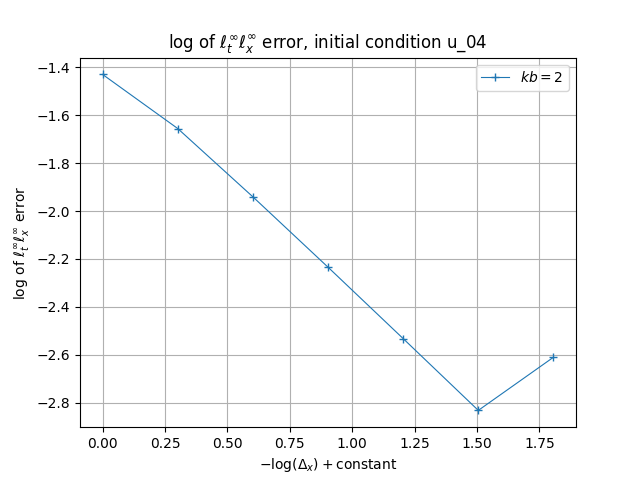

[0.03721155165659151,
 0.02211636999100941,
 0.011468710956294426,
 0.005830136184667767,
 0.0029340705151904567,
 0.0014706859837635422,
 0.002451619910197711]

In [34]:
%matplotlib notebook

error_linftyt_linftyx(u_04,g1,t,0.7,2,bw, 'naive')

For $r\geq 2$ (here for the Beam-warming scheme, so still for a second order scheme), the order seems to fall around 1 (even a bit less).

<IPython.core.display.Javascript object>


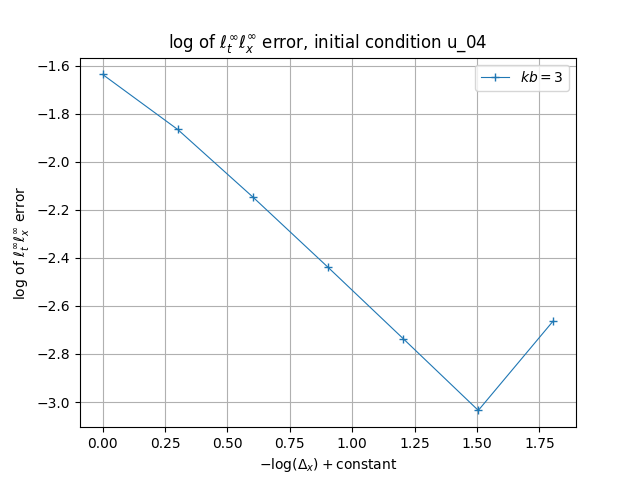

[0.0230922583209493,
 0.013624780267211922,
 0.007131870439651855,
 0.0036383136592962884,
 0.0018365879113472205,
 0.0009231175552618098,
 0.002180550631617706]

In [36]:
%matplotlib notebook

error_linftyt_linftyx(u_04,g1,t,0.7,3,O3, 'naive')

It also seems to fail to keep the order for the O3 scheme: the observed order is a bit less than 2.

## Inverse Lax-Wendroff

<IPython.core.display.Javascript object>


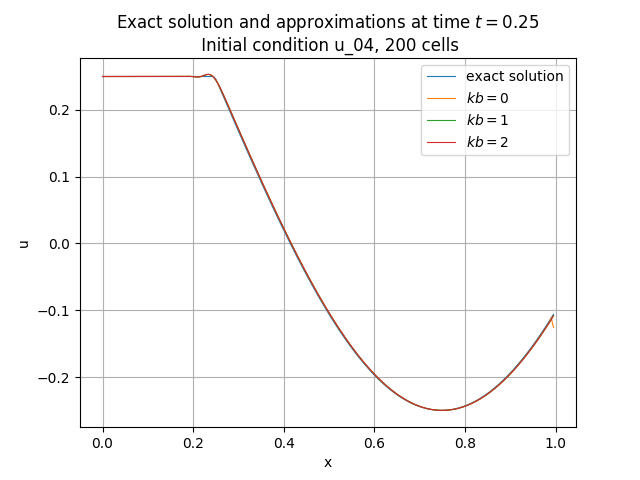

In [63]:
%matplotlib notebook

t = 0.25

sol_plot(u_04,g2, t, 200, 0.7, lw, 'ILW')

<IPython.core.display.Javascript object>


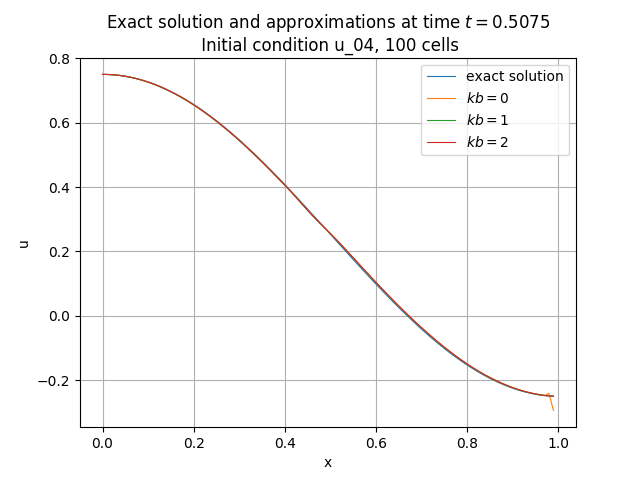

In [69]:
%matplotlib notebook

t = 0.5075

sol_plot(u_04,g1, t, 100, 0.7, lw, 'ILW')

<IPython.core.display.Javascript object>


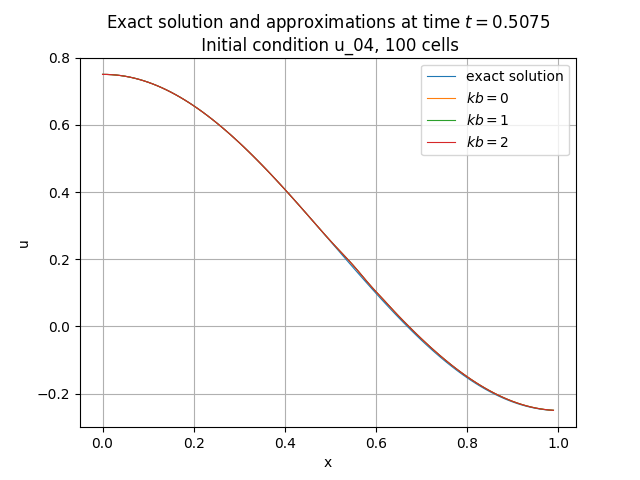

In [65]:
%matplotlib notebook

t = 0.5075

sol_plot(u_04,g1, t, 100, 0.7, bw, 'ILW')

<IPython.core.display.Javascript object>


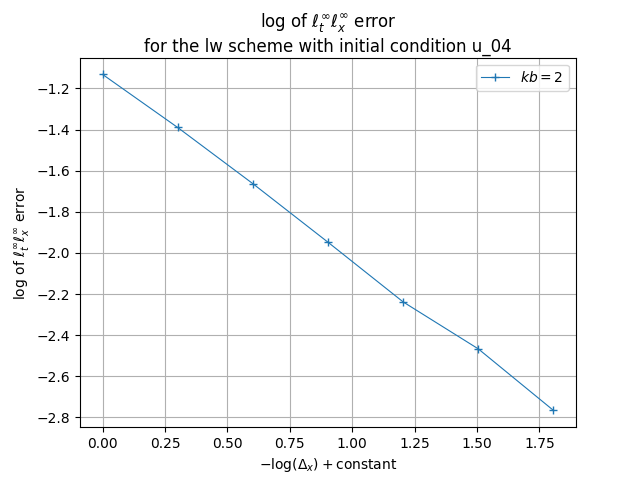

[0.07383693845165867,
 0.040740844715088986,
 0.021719900776081547,
 0.011272588579447906,
 0.005777871251163469,
 0.003414551070823224,
 0.001714660990660477]

In [70]:
%matplotlib notebook

error_linftyt_linftyx(u_04,g1,t,0.7,2,lw, 'ILW')

<IPython.core.display.Javascript object>


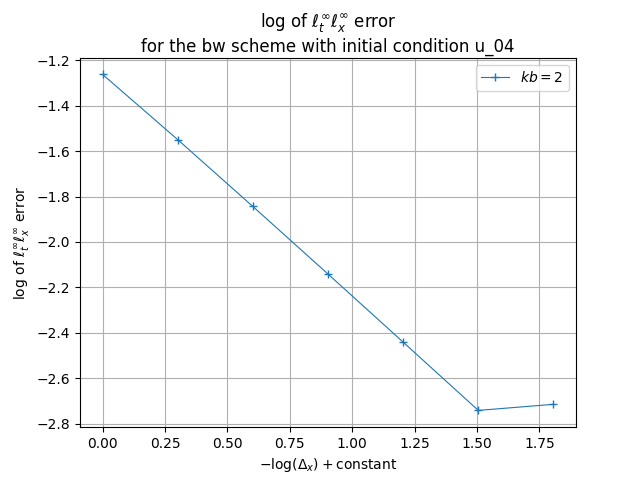

[0.05466710862408369,
 0.02822039937227827,
 0.0143312076353167,
 0.007224362783210481,
 0.0036222628347807873,
 0.001813022187972635,
 0.001928510218399071]

In [94]:
%matplotlib notebook

error_linftyt_linftyx(u_04,g1,t,0.7,2,bw, 'ILW')

<IPython.core.display.Javascript object>


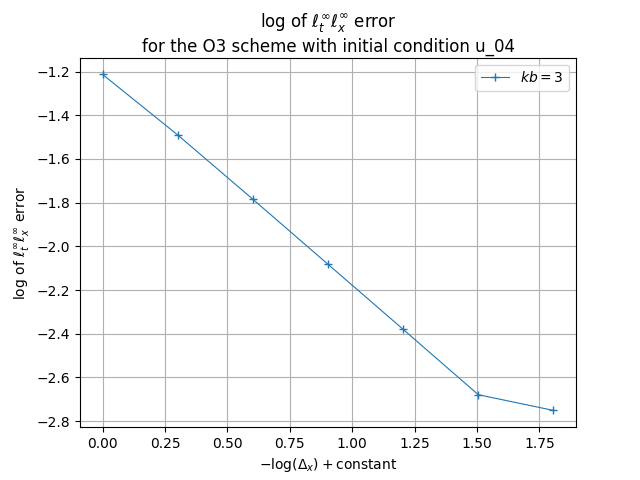

[0.06121558314888487,
 0.03233834497811788,
 0.016429563705888106,
 0.008278790333109243,
 0.004170665863379774,
 0.0020944687537155504,
 0.0017754307286398097]

In [95]:
%matplotlib notebook

error_linftyt_linftyx(u_04,g1,t,0.7,3,O3, 'ILW')

Problem with O3 scheme with the number of points used  to compute the derivative.

## Rectified ILW

<IPython.core.display.Javascript object>


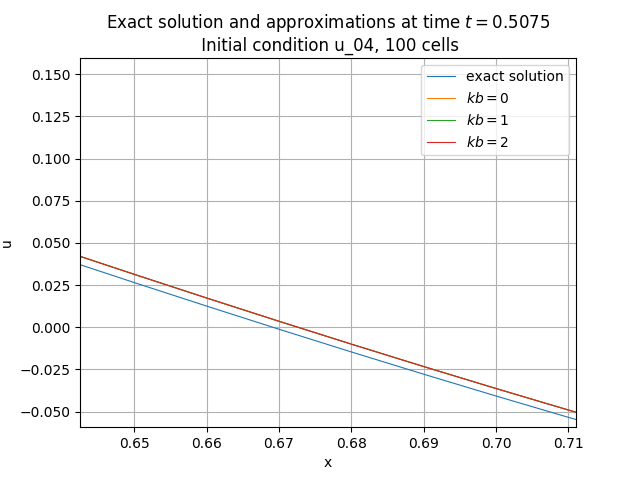

In [10]:
%matplotlib notebook

sol_plot(u_04,g1, t, 100, 0.7, lw, 'RILW')

<IPython.core.display.Javascript object>


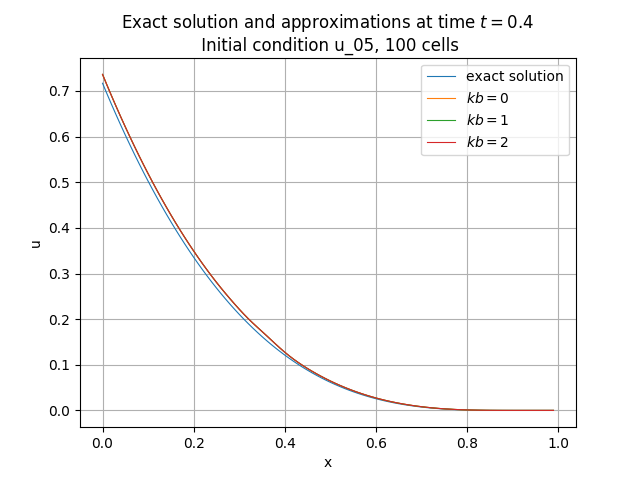

In [6]:
%matplotlib notebook

sol_plot(u_05,lambda t: (t+0.5)**3, 0.4, 100, 0.7, lw, 'RILW')

<IPython.core.display.Javascript object>


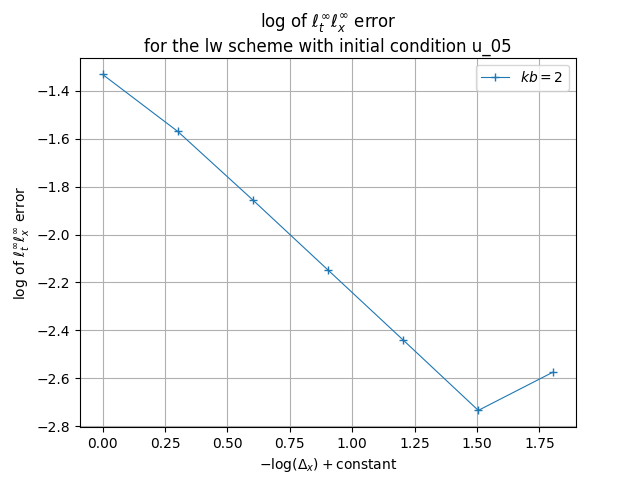

[0.04653896624999998,
 0.026920535930306466,
 0.013927751408019856,
 0.007110288049763519,
 0.0036301733060803143,
 0.0018462078645674063,
 0.0026719028549194723]

In [86]:
%matplotlib notebook

error_linftyt_l2x(u_05,lambda t: (t+0.5)**3,t,0.7,2,lw, 'RILW')

<IPython.core.display.Javascript object>


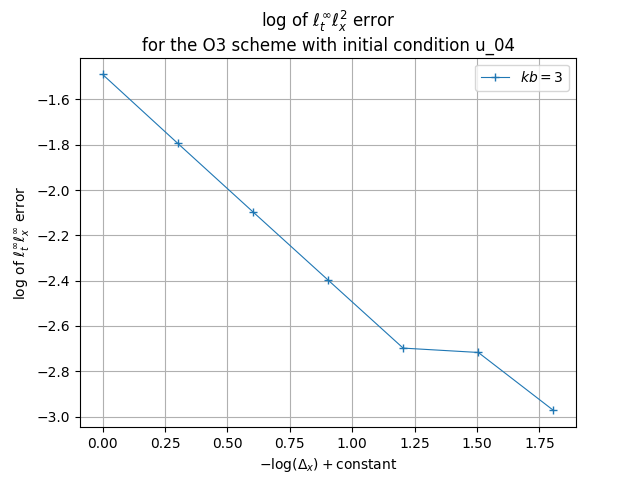

[0.03241564227604543,
 0.016086978305261113,
 0.008018548926693585,
 0.0040077234798196,
 0.0020049925752820786,
 0.001917922331398741,
 0.0010641760876451748]

In [11]:
%matplotlib notebook

error_linftyt_l2x(u_04,g1,t,0.7,3,O3, 'RILW')

# Test cell

In [46]:
2.6/1.75

1.4857142857142858

<IPython.core.display.Javascript object>


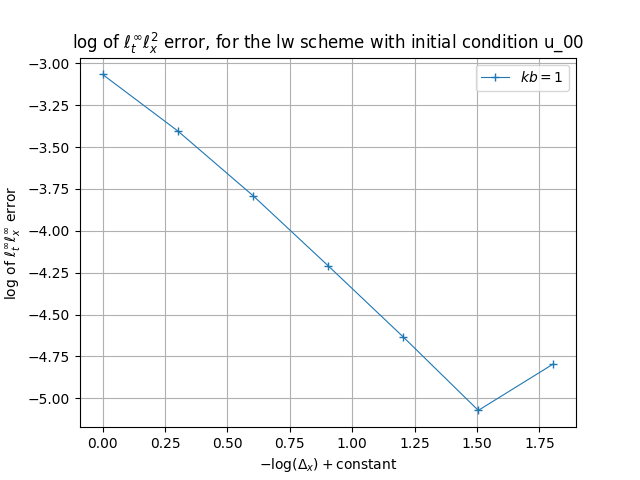

[0.0008577747680592348,
 0.00039467462340718034,
 0.00016238289877944158,
 6.194946236417948e-05,
 2.3274894721152447e-05,
 8.471240208803099e-06,
 1.6057724714376078e-05]

In [16]:
%matplotlib notebook

error_linftyt_l2x(u_00,lambda t : 0,t,0.7,1,lw, 'homogeneous')

In [97]:
2/1.5

1.3333333333333333